# Ensemble Learning
## Name: Nguyen Anh Hoang Phuc

## Blending

## Problem 1 Blending scratch mounting

Show at least three​ ​examples of scratch implementation of blending that are more accurate than a single model. Higher accuracy means less mean squared error (MSE) on the validation data.

### What is blending?

Blending is a method of independently training N diverse models, weighting the estimation results, and then adding them together. The simplest is to take the average. Various models are created by changing the following conditions.

- Techniques (eg linear regression, SVM, decision tree, neural network, etc.)
- Hyperparameters (eg SVM kernel type, initial weights, etc.)
- How to preprocess input data (eg standardization, logarithmic transformation, PCA, etc.)


The important thing is that each model is very different.

Blending in regression problems is so simple that it is not provided in scikit-learn.

<< Supplement >>

In the case of a classification problem, a majority vote will be taken. Because it is more complicated than regression problems, scikit-learn provides a Voting Classifier.

sklearn.ensemble.VotingClassifier — scikit-learn 0.21.3 documentation

In [1]:
# Library import
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Import the training model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline 
from sklearn.cross_decomposition import PLSRegression 

In [3]:
# Evaluation index
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
mini_data = data[['GrLivArea', 'YearBuilt', 'SalePrice']]

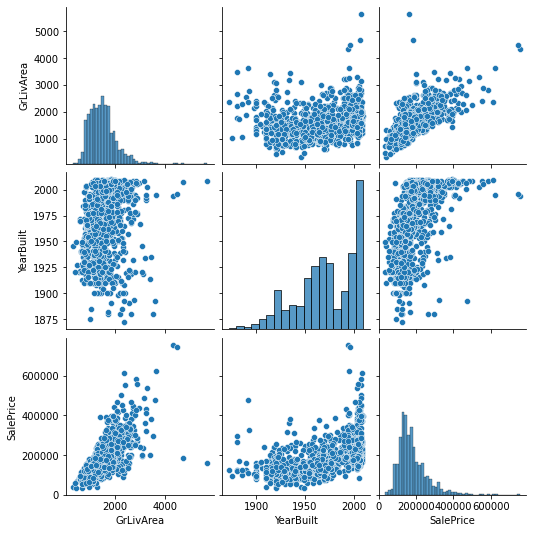

In [6]:
# Dataset visualization to use
sns.pairplot(mini_data)

In [7]:
# Logarithmic transformation
log_min_data = mini_data.apply(np.log1p)

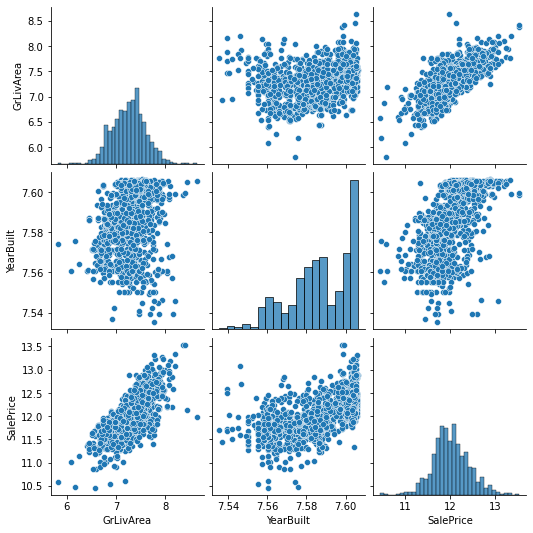

In [8]:
# Dataset visualization after logarithmic transformation
sns.pairplot(log_min_data)

In [9]:
# Explanatory variable X, objective variable y
X = log_min_data[["GrLivArea", "YearBuilt"]].values
y = log_min_data["SalePrice"].values 

- Single model 

In [10]:
# Train and estimate with a single model
# Cross-validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [11]:
# Single model
model = [LinearRegression(), SVR(), DecisionTreeRegressor()]

In [12]:
# Cross-validation (cross-validation)
kf = KFold(n_splits=5, random_state=None, shuffle=False)

In [13]:
# Metrics MSE, validated in 5 parts
for regr in model:
    result = -cross_val_score(regr, X, y, cv=kf,scoring="neg_mean_squared_error")
    result_mean = np.mean(result)

    # print("CV_MSE: ", result)
    print("CV_MSE_MEAN:{:.3f}".format(result_mean), "MODEL:", str(regr))

CV_MSE_MEAN:0.046 MODEL: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CV_MSE_MEAN:0.047 MODEL: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
CV_MSE_MEAN:0.073 MODEL: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [14]:
# Split into training data and validation data (holdout method)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,random_state=None)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

X_train: (1168, 2)
y_train: (1168,)
X_valid: (292, 2)
y_valid: (292,)


## Blending 1

In [15]:
# Blending 1
regr1 = LinearRegression().fit(X_train,y_train)
regr2 = SVR().fit(X_train,y_train)
regr3 = DecisionTreeRegressor().fit(X_train,y_train)

y_pred1 = regr1.predict(X_valid)
y_pred2 = regr2.predict(X_valid)
y_pred3 = regr3.predict(X_valid)

# Average the estimates
y_pred_blend1 = np.mean([y_pred1, y_pred2, y_pred3], axis=0)

# Rating
mse = mean_squared_error(y_valid, y_pred_blend1)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_blend1)

print("MSE: {:.3f}".format(mse))
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))

MSE: 0.046
RMSE: 0.215
R2: 0.696


- Slight performance improvement over single model MSE 0.046
## Blending 2

In [16]:
# Cross-validation (cross_validation)
kf = KFold(n_splits=5,random_state=None,shuffle=False)

params = [1,10,20]

# Metrics MSE, validated in 5 parts
for rn in params:
    # Single model
    regr = DecisionTreeRegressor(random_state=rn)
    result = -cross_val_score(regr, X, y, cv=kf, scoring="neg_mean_squared_error")
    result_mean = np.mean(result)

    # print("CV_MSE: ", result)
    print("CV_MSE_MEAN:{:.3f}".format(result_mean), "MODEL:", str(regr))

CV_MSE_MEAN:0.071 MODEL: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')
CV_MSE_MEAN:0.072 MODEL: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=10, splitter='best')
CV_MSE_MEAN:0.070 MODEL: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=No

In [17]:
# Blending 2
regr1 = DecisionTreeRegressor(random_state=1).fit(X_train, y_train)
regr2 = DecisionTreeRegressor(random_state=10).fit(X_train, y_train)
regr3 = DecisionTreeRegressor(random_state=20).fit(X_train, y_train)

y_pred1 = regr1.predict(X_valid)
y_pred2 = regr1.predict(X_valid)
y_pred3 = regr1.predict(X_valid)

# Average the estimation
y_pred_blend2 = np.mean([y_pred1, y_pred2, y_pred3], axis=0)
# print(y_pred)

# Rating
mse = mean_squared_error(y_valid, y_pred_blend2)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_blend2)

print("MSE: {:.3f}".format(mse))
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))

MSE: 0.073
RMSE: 0.270
R2: 0.522


## Blending 3

In [18]:
# Standardization
from sklearn.preprocessing import StandardScaler 

std_mini_data = StandardScaler().fit_transform(mini_data)

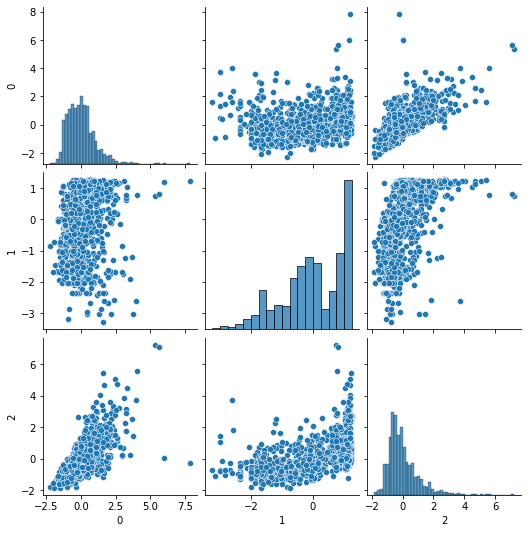

In [19]:
# Data set visualization after standardization
sns.pairplot(pd.DataFrame(std_mini_data))

In [20]:
# Explanaroty variable X, objective variable y
X = std_mini_data[:,:-1]
y = std_mini_data[:,-1]

In [21]:
# Split into training data and validation data (holdout method)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,random_state=None)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

X_train: (1168, 2)
y_train: (1168,)
X_valid: (292, 2)
y_valid: (292,)


In [22]:
# Single model
model = [LinearRegression(), SVR(), DecisionTreeRegressor()]

# Cross-validation (cross-validation)
kf = KFold(n_splits=5, random_state=None, shuffle=False)

# Metrics MSE, validated in 5 parts
for regr in model:
    result = -cross_val_score(regr, X, y, cv=kf,scoring="neg_mean_squared_error")
    result_mean = np.mean(result)

    # print("CV_MSE: ", result)
    print("CV_MSE_MEAN:{:.3f}".format(result_mean), "MODEL:", str(regr))

CV_MSE_MEAN:0.352 MODEL: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CV_MSE_MEAN:0.314 MODEL: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
CV_MSE_MEAN:0.452 MODEL: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [23]:
# Blending 2
regr1 = LinearRegression().fit(X_train,y_train)
regr2 = SVR().fit(X_train,y_train)
regr3 = DecisionTreeRegressor().fit(X_train,y_train)

y_pred1 = regr1.predict(X_valid)
y_pred2 = regr2.predict(X_valid)
y_pred3 = regr3.predict(X_valid)

# Average the estimates
y_pred_blend3 = np.mean([y_pred1, y_pred2, y_pred3], axis=0)

# Rating
mse = mean_squared_error(y_valid, y_pred_blend3)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred_blend3)

print("MSE: {:.3f}".format(mse))
print("RMSE: {:.3f}".format(rmse))
print("R2: {:.3f}".format(r2))

MSE: 0.333
RMSE: 0.577
R2: 0.642


Performance improved to 0.333 compared to 0.352 for the single model MSE (lower than the logarithmic transformation)

## Bagging

## Problem 2 Scratch mounting of bagging

Please show at least one​ ​example where you scratch-implement the bagging and it is more accurate than a single model.

## What is bagging?

Bagging is a way to diversify how to select input data. N types of subsets (bootstrap samples) are created by randomly extracting from the training data after allowing duplication. N models are trained by them and the estimation results are averaged. Unlike blending, each weighting does not change.

sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation

Data can be split randomly by using scikit-learn's train_test_split with the shuffle parameter set to True. This will give you a bootstrap sample.

The part that averages the estimation results is implemented in the same way as boosting.

In [24]:
# Explanatory variable X, objective variable y
X = log_min_data[["GrLivArea", "YearBuilt"]].values
y = log_min_data["SalePrice"].values 

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,random_state=None)

In [26]:
# Single model
model = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = model.predict(X_valid)

# Rating
mse = mean_squared_error(y_valid, y_pred)
print("MSE: {:.3f}".format(mse))

MSE: 0.074


In [27]:
# Bagging
n = 20
models = []

for i in range(n):
    X_bagging, X_, y_bagging, y_ = train_test_split(X_train, y_train, train_size=0.2, shuffle=True)
    
    model = DecisionTreeRegressor()
    model.fit(X_bagging, y_bagging)
    models.append(model)

y_pred = np.zeros(len(X_valid))

for regr in models:
    pred = regr.predict(X_valid)
    y_pred = y_pred + pred

y_pred = y_pred/n

# Rating 
mse = mean_squared_error(y_valid,y_pred)
print("MSE: {:.3f}".format(mse))

MSE: 0.047


## Stacking
## Problem 3 Stacking scratch mounting

Please show at least one​ ​example where stacking is scratch-implemented and more accurate than a single model.

What is stacking?

The stacking procedure is as follows. Stacking is possible if there is at least stage 0 and stage 1, so implement it. First, set about $K_0=3, M_0=2$.

《When learning》

(Stage $0$)

    Divide the training data into $K_0$ pieces.
    The combination of $(K_0-1)$ pieces of the divided data can be made as learning data, and the remaining $1$ pieces can be made as estimation data to make $K_0$ pieces.
    Prepare $K_0$ instances of a model and learn using different learning data.
    For each trained model, input the remaining $1$ unused estimation data and obtain the estimated value. (This is called blend data)
    In addition, prepare $K_0$ instances of different models and do the same. If there are $M_0$ models, $M_0$ blend data can be obtained.


(Stage $n$)

    Consider the blended data of stage $n-1$ as learning data having $M_{n-1}$ dimensional features and divide it into $K_n$ pieces. The same applies hereinafter.


(Stage $N$) *Last stage

    One kind of model is trained by using $M_{N-1}$ blended data of stage $N-1$ as input of $M_{N-1}$ dimensional features. This is the model that makes the final estimation.


《Estimated time》

(Stage $0$)

    Input test data into $K_0 × M_0$ trained models and obtain $K_0 × M_0$ estimates. The average value is calculated on the $K_0$ axis, and data with $M_0$ dimensional features is obtained. (Called the blend test)


(Stage $n$)

    Input the blend test obtained at stage $n-1$ into $K_n×M_n$ trained models and obtain $K_n×M_n$ estimates. The average value is calculated on the axis of $K_n$, and the data with the $M_0$-dimensional feature quantity is obtained. (Called the blend test)


(Stage $N$) *Last stage

    Input the blend test obtained in the stage $N-1$ into the trained model to obtain the estimated value.


In [28]:
class Stacking():
    """
    Class for stacking
    Parameters
    ----------
    max_depth: int 
      Maximum learning depth for stacking
    splits: int
      Number of data divisions when creating blend data (number of CV divisions)
    models: dictionary
      Pass in the training model (key:n_depth, valuesL model).
    fit_models: list
      List of trained models to be saved
    """
    def __init__(self, max_depth, splits, models):
        self.max_depth = max_depth
        self.n_splits = splits
        self.models = models 
        self.fit_models = []

    def blending(self,X,y,m):
        """
        Function to create blend data
        Parameters
        -----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data   
        y : ndarray of the following form, shape (n_samples,)
            Label value of training data
        m : class
            Instances of the training model
        """
        self.y_blend = np.zeros(len(X))

        kf = KFold(n_splits=self.n_splits, shuffle=False)

        # CV
        for train_index, valid_index in kf.split(X):
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

            y_train = y_train.ravel()
            y_valid = y_valid.ravel()

            # Training model creation with train data
            regr = m
            regr.fit(X_train, y_train)
            # print(regr.predict(X_valid))
            self.fit_models.append(regr)

            # Blend data creation
            self.y_blend[valid_index] = regr.predict(X_valid)

    def fit_(self,X,y,depth):
        """
        Function to create blending data at this depth
        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data   
        y : ndarray of the following form, shape (n_samples,)
            Label value of training data
        depth : int
            The depth of this stage
        """
        self.depth = depth 
        
        # Final learning model
        if self.depth == self.max_depth:
            self.model = self.models[self.depth]
            self.model.fit(X,y)
            return 
        
        # Prepare a training model for this depth
        models = self.models[self.depth]
        self.y_blending = np.zeros([len(X),len(models)])

        # Create blended data with a training model of this depth
        for i, mdl in enumerate(models):
            self.blending(X,y,mdl)
            self.y_blending[:,i] = self.y_blend 

        # X(blend_y) for the next stage
        blend_y = self.y_blending

        # recursive
        self.bld = Stacking(self.max_depth, self.n_splits, self.models)
        self.bld.fit_(blend_y,y,depth+1)

    def predict_(self, X):
        if self.depth == self.max_depth:
            y_pred = self.model.predict(X)
            return y_pred 
        else:
            tmp = 0
            self.y_pred = np.zeros(len(X))
            self.y_next = np.zeros([len(X),len(self.models[self.depth])])

            for mdl in self.fit_models:
                tmp += 1
                self.y_pred += mdl.predict(X)

                if tmp % self.n_splits == 0:
                    self.y_pred = self.y_pred/self.n_splits
                    self.y_next[:,int(tmp/self.n_splits)-1] = self.y_pred 
                    self.y_pred = np.zeros(len(X))
                    
            y_pred = self.bld.predict_(self.y_next)
        
        return y_pred

In [29]:
# Explanatory variable X, objective variable y
X = log_min_data[["GrLivArea", "YearBuilt"]].values
y = log_min_data["SalePrice"].values 

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,random_state=None)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_valid:", X_valid.shape)
print("y_valid:", y_valid.shape)

X_train: (1168, 2)
y_train: (1168,)
X_valid: (292, 2)
y_valid: (292,)


In [31]:
model = {0:[LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()],
         1:[ARDRegression(), SGDRegressor(),DecisionTreeRegressor()],
         2:[HuberRegressor(), ARDRegression(), RandomForestRegressor()],
         3:LinearRegression()
         }

stk = Stacking(max_depth=3, splits=5, models=model)
stk.fit_(X_train, y_train, 0)
y_pred = stk.predict_(X_valid)
print(y_pred)

# Rating
mse = mean_squared_error(y_valid, y_pred)
print("MSE: {:.3f}".format(mse))

[12.5005222  11.52846387 11.8436703  11.89827653 12.36190072 11.87300211
 12.2352709  12.27452096 12.31482709 11.42012118 11.98250992 12.0443531
 12.27155834 12.45142374 11.71677271 11.67943265 11.62187534 12.4203275
 11.74476841 12.20103264 11.78344058 11.61420421 12.25223817 11.61738954
 12.32251657 12.26731661 12.32041688 11.91960114 12.22855855 11.2744295
 11.9320846  11.78785727 12.21213078 11.93148516 11.79129896 12.27562558
 12.36086728 11.883682   12.1977691  11.73696197 11.70058574 12.50122672
 12.65286988 11.73738439 11.45617903 12.23834314 12.33584137 11.65995339
 12.06841779 11.54871837 12.08489965 12.45363706 11.99014761 13.02597593
 12.11173857 11.7346636  12.20607148 12.38797208 12.45632258 12.01284081
 12.30587082 12.2938717  12.4180951  11.6140389  11.68390146 12.2485086
 12.30674677 12.4559946  11.77377318 12.10920758 12.04151892 12.24598282
 11.60906294 11.88424929 12.35873809 12.15479641 12.18438293 12.85974971
 12.47362248 11.58505418 12.4923274  12.26584641 11.883

## Sprint summary Ensemble learning (blending, bagging, stacking)
- Best of a single model 0.046
- Bleding 0.043
- Bagging 0.053
- Stacking 0.038